# Evaluation
(by Tevfik Aytekin)

Below are some commonly experimental protocols and metrics for evaluating the performance of regression and classification models. Note that there are many other metrics which can be used for evaluation. There is no best metric, instead every metric has some set of properties and should be used according to the specific needs of the user.

In [2]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## Experiment types for estimating the accuracy/error of a model

After we train the model on a training set, if we measure accuracy on the training set that will give us an optimistically biased estimate of hypothesis accuracy over future examples. In order to get an **unbiased estimate of future accuracy of our model** we measure the accuracy of our model on a seperate test set. We will look at some of the common train/test split types.

### Holdout Method
In this method the dataset is divided into two disjoint sets: training and test sets. A model is built using the training set and its performance is evaluated on the test set. Typical percentages of training and test sets can be 80% and 20% respectively. In order to increase the reliability, this method can be repeated which is named random subsampling. One important limitation of this method is that since the training and test sets are formed randomly, some examples might never appear in the training or test set.

#### Single Holdout

In [5]:
train = pd.read_csv("../datasets/house_prices/train.csv")


X = train.loc[:,['GrLivArea','BedroomAbvGr']]
y = train.loc[:,'SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
test_predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, test_predictions)

print("Test MAE:", mae)

Test MAE: 39004.515071632035


Training error is a biased estimate of the model's true error.

In [6]:
train_predictions = model.predict(X_train)
mae = mean_absolute_error(y_train, train_predictions)
rf = RandomForestRegressor()
model = rf.fit(X_train, y_train)
test_predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, test_predictions)

print("Test MAE:", mae)

train_predictions = model.predict(X_train)
mae = mean_absolute_error(y_train, train_predictions)

print("Train MAE:", mae)

Test MAE: 40867.68212756225
Train MAE: 17233.13457908078


#### Repeated Holdout

In [61]:

X = train.loc[:,['GrLivArea','BedroomAbvGr']]
y = train.loc[:,'SalePrice']
mae = []
for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())

    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions))
    print(mae[i])
print("Test MAE:", np.mean(mae))


35538.45468702017
35002.63829183467
36682.05644264404
35956.03538220402
37743.55519809224
38988.27173278897
32125.9991341496
31368.032785778916
33348.48300936318
35175.15412060003
Test MAE: 35192.86807844758


### Cross-Validation
In this method the dataset is divided in to $k$ equal sized partitions. The experiment in repeated $k$ times such that in each run one of the partitions in used as a test set and the remaining parititons are used as the training set. Typical values of $k$ are 5 and 10. In the extreme case $k$ can be set to the size of the dataset, this special case is called leave-one-out-cross-validation (LOOCV). LOOCV is used when the dataset size is too small (such as 100) and you don't want to waste your examples by putting them into the test set.

#### k-fold cross validation

Example of 5-fold cross-validation on a dataset with 10 samples:

In [64]:
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
kf = KFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(X):
    print("%s %s" % (train_index, test_index))


[0 1 2 3 5 6 7 8] [4 9]
[0 1 2 3 4 6 7 9] [5 8]
[2 3 4 5 6 7 8 9] [0 1]
[0 1 3 4 5 7 8 9] [2 6]
[0 1 2 4 5 6 8 9] [3 7]


#### LOOCV Example

In [65]:
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    print("%s %s" % (train_index, test_index))


[1 2 3 4 5 6 7 8 9] [0]
[0 2 3 4 5 6 7 8 9] [1]
[0 1 3 4 5 6 7 8 9] [2]
[0 1 2 4 5 6 7 8 9] [3]
[0 1 2 3 5 6 7 8 9] [4]
[0 1 2 3 4 6 7 8 9] [5]
[0 1 2 3 4 5 7 8 9] [6]
[0 1 2 3 4 5 6 8 9] [7]
[0 1 2 3 4 5 6 7 9] [8]
[0 1 2 3 4 5 6 7 8] [9]


Randomized 5-fold cross-validation on a dataset with 10 samples:

In [66]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)
for train_index, test_index in ss.split(X):
    print("%s %s" % (train_index, test_index))

[9 1 6 7 3 0 5] [2 8 4]
[2 9 8 0 6 7 4] [3 5 1]
[4 5 1 0 6 9 7] [2 3 8]
[2 7 5 8 0 3 4] [6 1 9]


10-fold CV on house prices dataset

In [67]:

X = train.loc[:,['GrLivArea','BedroomAbvGr']]
y = train.loc[:,'SalePrice']
mae = []
n_folds = 10
kf = KFold(n_splits=n_folds)
i = 0
for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index,:].fillna(X.iloc[train_index,:].mean())
    X_test = X.iloc[test_index,:].fillna(X.iloc[test_index,:].mean())
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions))
    print(mae[i])
    i = i+1
print("Test MAE:", np.mean(mae))



33463.42816890123
35766.15090561075
33813.451788008686
34668.9382815904
42460.86478874594
32911.60713974028
33801.44230928506
32741.035676616124
43151.135448046174
36634.72547195214
Test MAE: 35941.27799784967


In [70]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)
print(scores)

[-33463.4281689  -35766.15090561 -33813.45178801 -34668.93828159
 -42460.86478875 -32911.60713974 -33801.44230929 -32741.03567662
 -43151.13544805 -36634.72547195]


## Metrics for Regression

#### Mean Absolute Error (MAE)

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Properties:
- Can be used for regression problems

#### Mean Squared Error (MSE)

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

Properties:
- Can be used for regression problems
- Penalizes large errors more compared to MAE. So, more sensitive to outliers than MAE

#### Root Mean Squared Error (RMSE)

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Properties:
- Similar to MSE but scales the error back to the scale of the target values.
- Since square root is a nondecreasing function, if a result $a$ is better than $b$ with respect to MSE than $a$ is also better than $b$ with respect to RMSE.

#### The Coefficient of Determination, r-squared ($r^2$)

$$ r^2 = 1 - \frac{MSE_{model}}{MSE_{mean}}$$ 

where $MSE_{mean}$ is the MSE of the baseline model which always predicts the mean of the target values in the training set.

Properties:
- Evaluates the performance of your model with respect to a baseline.

#### Mean Absolute Percentage Error (MAPE)

$$MAPE = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_i - \hat{y}_i}{y_i}\right|*100$$

Properties:
- Gives a scaled error value independent of the magnitude of the target values.
- Problematic when the target value is 0 or very close to 0.

In [71]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
train = pd.read_csv("../datasets/house_prices/train.csv")
X = train[['GrLivArea']]
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
model_slr = linear_model.LinearRegression()
model = model_slr.fit(X_train, y_train)
train_predictions = model_slr.predict(X_train)
test_predictions = model_slr.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, test_predictions))
print("Test MSE:", mean_squared_error(y_test, test_predictions))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_predictions)))
print("Test r-squared:", r2_score(y_test, test_predictions))
print("Test MAPE:",np.mean(np.abs((y_test - test_predictions) / y_test)) * 100);

Test MAE: 43965.34202802577
Test MSE: 4701756721.122332
Test RMSE: 68569.35701260682
Test r-squared: 0.5779464703078228
Test MAPE: 24.806580418103877


1000 examples in the test set.
900 them are positive
100 of them are negative

Model always predicts positive.

Accurracy = 90%

TP = 4
FP = 3
TN = 3
FN = 0

Acc = 900 / 1000
Precision of class 1 = 900 / 1000
Recall of class 1 = 900 / 900 = 1

Precision of class 0/0 = 0
Recall of class 0 = 0

## Metrics for Classification

#### Confusion Matrix
<img src="images/confusion_matrix.png" style="max-width:100%; width: 40%">

- TP: the number of cases where both actual and predicted values are positive
- FN: the number of cases where actual value is positive but predicted value is negative
- FP: the number of cases where actual value is negative but predicted value is positive
- TN: the number of cases where both actual and predicted values are negative


#### Accuracy
$$ Accuracy = \frac{TP+TN}{TP+FN+FP+TN}$$

#### Precision
$$ Precision = \frac{TP}{TP+FP}$$

#### Recall
$$ Recall = \frac{TP}{TP+FN}$$

#### F-measure
$$ F_1 = \frac{2*Precision*Recall}{Precision+Recall}$$

#### Kappa

$$ \kappa = \frac{p_a-p_e}{1-p_e}$$

where $p_a$ is the accuracy of the model and $p_e$ is the expected accuracy of pure chance.

#### ROC Curve and AUC

ROC Curves can be used to evaluate the performance of a classifier which produces a probabilistic output for class membership. When the classifier produces a probabilistic output, you have the chance to put a threshold for class membership. ROC curve is generated by moving the threshold to different values and find the true positive rate (tpr) and false positive rate (fpr) at these thresholds. Area under the curve (AUC) is the total area under the ROC curve. Classifiers whose AUC is larger are better classifiers.

Below are the definitions that are needed to undertand ROC curves.

$$
True \: Positive\: Rate\:(TPR) = Recall = Sensitivity =  \frac{TP}{TP+FN}
$$

$$
Specificity = \frac{TN}{TN+FP}
$$

$$
False\: Positive\: Rate\:(FPR) = 1 - Specificity =  \frac{FP}{FP+TN}
$$


In [72]:
def f_measure(p, r):
    return (2*p*r)/(p+r)

In [73]:
p1 = 0.9
r1 = 0.1

p2 = 0.5
r2 = 0.5
print(f_measure(p1,r1))
print(f_measure(p2,r2))

0.18000000000000002
0.5


In [74]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ['age', 'gender', 'cp', 'trestbps', 'chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','diagnosis']
heart = pd.read_csv(url, names=names, na_values=["?"])
heart.head(5)

,age,gender,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split  

X = heart.iloc[:,0:12]
y = heart.iloc[:,13]
y = y.replace([1,2,3,4],[1,1,1,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=3)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf1 = KNeighborsClassifier(n_neighbors=10)
clf2 = DecisionTreeClassifier(min_samples_split=20)
clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);
y_pred1 = clf1.predict_proba(X_test)  
y_pred2 = clf2.predict_proba(X_test)  

The table below shows the probabilities of being a positive example produced by KNN and DTree models. Given these results which model is better? 

In [85]:
# Class values and predicted class probabilities, thresholds, tpr, fpr
pd.options.display.float_format = '{:,.1f}'.format
results = pd.DataFrame([y_test.values, 
                y_pred1[:, 1],
                y_pred2[:, 1]],
                index = ['Actual Class','Prob (KNN)','Prob (DTree)'])
results

,0,1,2,3,4,5,6,7,8,9
Actual Class,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
Prob (KNN),0.7,0.4,0.8,0.4,0.6,0.3,0.2,0.5,0.3,0.5
Prob (DTree),0.0,0.0,0.0,0.8,1.0,0.0,0.0,0.5,0.0,0.0


The difficulty with evaluating classifiers which produce probabilistic output lies in the fact that there are many possible thredholds we can use. And for every threshold the precision and recall values can change. One way to solve this problem is to calculate precision and recall values for every possible threshold and get a overall result. ROC curves do exactly this.

Sort the values with respect to KNN, calculate manually FPR, TPR values for every threshold, and plot the result.

In [77]:
results = results.sort_values(by ="Prob (KNN)", axis=1)
results.drop("Prob (DTree)")

,6,5,8,1,3,7,9,4,0,2
Actual Class,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
Prob (KNN),0.2,0.3,0.3,0.4,0.4,0.5,0.5,0.6,0.7,0.8


Sort the values with respect to DTree, calculate manually FPR, TPR values for every threshold, and plot the result.

In [78]:
results = results.sort_values(by ="Prob (DTree)", axis=1)
results.drop("Prob (KNN)")

,6,5,8,1,2,9,0,7,3,4
Actual Class,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
Prob (DTree),0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.5,0.8,1.0


We can do the same thing easily with roc_curve() function.

In [79]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1[:, 1],drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2[:, 1],drop_intermediate=False)
print("fpr1:",np.round(fpr1,2));
print("tpr1:",np.round(tpr1,2));
print("thresholds1:",np.round(thresholds1,2));
print("fpr2:",np.round(fpr2,2));
print("tpr2:",np.round(tpr2,2));
print("thresholds2:",np.round(thresholds2,2));

fpr1: [0.   0.33 0.33 0.33 0.33 0.67 1.   1.  ]
tpr1: [0.   0.   0.14 0.29 0.57 0.71 0.86 1.  ]
thresholds1: [1.8 0.8 0.7 0.6 0.5 0.4 0.3 0.2]
fpr2: [0. 0. 0. 0. 0. 1.]
tpr2: [0.   0.14 0.29 0.43 0.71 1.  ]
thresholds2: [2.   1.   0.82 0.5  0.14 0.  ]


Text(0, 0.5, 'True Positive Rate')

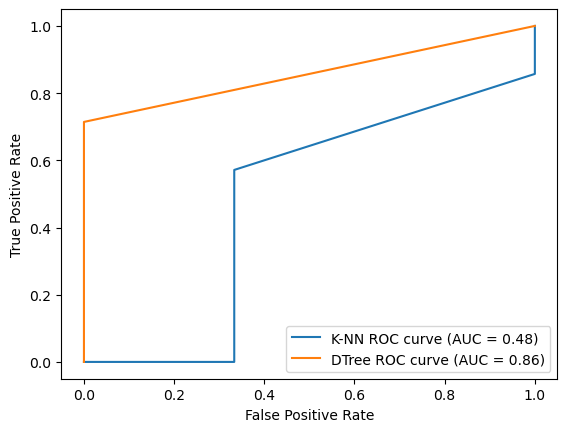

In [80]:
import matplotlib.pyplot as plt

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

plt.plot(fpr1,tpr1,label='K-NN ROC curve (AUC = %0.2f)' % auc1);
plt.plot(fpr2,tpr2,label='DTree ROC curve (AUC = %0.2f)' % auc2);
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

According to the above figure, DTree is a better classifier than K-NN since its AUC value is larger. AUC is a measure for comparing the performance of classifiers which produce probabilities for class membership. It is a way to sum up the performance of a classifier for all possible thresholds.


Below illustrates the two extreme cases: 

In [ ]:
y_test = [0,0,0,0,0,1,1,1,1,1]
y_pred1 = [0.15,0.1,0.2,0.12,0.18,0.68,0.62,0.92,0.88,0.72]
y_pred2 = list(reversed(y_pred1))
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1,drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2,drop_intermediate=False)

# Seems to be a bug in sklearn, even though in the documentation it says that 
# thresholds[0] is set to max(y_score) + 1, it is not. So, the following two 
# lines are needed to start the ROC curve at (0,0).
tpr1 = np.r_[0, tpr1] 
fpr1 = np.r_[0, fpr1] 

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

plt.plot(fpr1,tpr1,label='Best ROC curve (AUC = %0.2f)' % auc1);
plt.plot(fpr2,tpr2,label='Worst ROC curve (AUC = %0.2f)' % auc2);
plt.legend(loc="center")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Also compare the following cases, which one is a better classifier? In the test set there are 5 positive (green color) and 5 negative (blue color) examples. The arrays show the examples as sorted by predicted probabilities.

In [ ]:
# Case 1
y_test = np.array([0,0,0,0,0,1,1,1,1,1])
y_pred1 = np.array([0.15,0.1,0.2,0.12,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred1.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

In [ ]:
# Case 2
y_pred2 = np.array([0.63,0.1,0.2,0.12,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred2.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

In [ ]:
# Case 3
y_pred3 = np.array([0.69,0.1,0.2,0.12,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred3.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

In general the more blue's to the left the better the classifier. AUC score makes this vague characterization precise.

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1,drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2,drop_intermediate=False)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred3,drop_intermediate=False)


auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)

plt.plot(fpr1,tpr1,label='Case1 ROC curve (AUC = %0.2f)' % auc1);
plt.plot(fpr2,tpr2,label='Case2 ROC curve (AUC = %0.2f)' % auc2);
plt.plot(fpr3,tpr3,label='Case3 ROC curve (AUC = %0.2f)' % auc3);

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

<b>Question 1</b>: Can there be two different sequences of positive and negative examples such that their AUC values are the same?

<b>Question 2</b>: What are the disadvantages of ROC-curves? One disadvantage is false positives and false negative have the same misclassification costs, but in reality they can be different.

In [ ]:
# Case 4
y_pred4 = np.array([0.66,0.1,0.2,0.67,0.18,0.68,0.62,0.92,0.88,0.72])
sort_by_prob = y_test[y_pred4.argsort()]
plt.figure(figsize=(5,0.5))
plt.pcolor(sort_by_prob.reshape(1,10), edgecolors='k',  linewidths=2, cmap='winter')
plt.axis('off');

In [ ]:
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred4,drop_intermediate=False)

auc4 = auc(fpr4, tpr4)

plt.plot(fpr3,tpr3,label='Case3 ROC curve (AUC = %0.2f)' % auc3);
plt.plot(fpr4,tpr4,label='Case4 ROC curve (AUC = %0.2f)' % auc4);

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');